In [1]:
!pip install stop-words pymorphy2

In [2]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
max_words = 2000
max_len = 20
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [4]:
dataset_train  = 'train.csv'
dataset_test  = 'test.csv'
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=13)
df_train.head()

,id,label,tweet
24838,24839,0,#dreamcatcher bull up: you will dominate you...
18674,18675,0,@user when are you releasing the remix album.....
20179,20180,0,"vegas on sunday with my bff, her bf, and my bf"
1219,1220,0,happy monday everyone! lets make it a good wee...
19636,19637,0,mimando a mis compis del trabajo #cumpleaÃ±os ...


In [7]:
df_valid.head()

,id,label,tweet
9621,9622,0,not long now ... @user thank you for a beautif...
3388,3389,0,time to follow up the words and send somebody ...
12766,12767,0,if i posted a picture of a different #fingerpu...
24031,24032,0,@user reagan america was always at the forefro...
17357,17358,0,can't believe it's nearly been one week at my ...


In [8]:
sw = set(stopwords.words('english'))
print(sw)

{"haven't", 'weren', 'or', 't', 'ourselves', 'be', 're', "should've", 'd', 'out', 'when', 'does', 'why', 'few', 'he', 'ma', 'down', "shan't", "you'd", 've', 'it', 'wasn', "shouldn't", 'any', 'themselves', 'each', 'will', "you're", 'yourselves', 'an', 'not', 'this', 'is', 'its', 'own', 'again', 'the', "couldn't", 'who', 'couldn', "don't", 'no', 'than', 'their', 'am', 'yourself', 'him', 'through', "mightn't", 'being', 'so', 'me', 'here', 'very', 'same', 'himself', 'they', 'itself', 'was', 'which', 'has', 'hadn', 'hasn', 'isn', 'such', 'been', 'those', 'don', 'them', 'because', 'between', "aren't", 'up', 'nor', "doesn't", 'then', 'do', 'against', 'during', 'off', 'are', 'under', 'with', 'more', 'as', 'to', "it's", 'a', 'from', 'how', 'myself', 'about', 'until', 'most', 'and', "wouldn't", "she's", 'too', 'm', 'haven', "you'll", "you've", "hadn't", 'theirs', 'ours', "weren't", 'both', 'only', 'wouldn', 'above', 's', 'mustn', 'your', 'once', 'by', 'our', 'had', 'whom', 'over', 'were', 'yours

In [9]:
exclude = set(punctuation)
print(exclude)

{'%', '&', "'", '[', '|', '>', '/', '(', ',', '^', '!', '+', '{', '.', ':', '_', '$', ']', '#', '}', '?', '=', '*', '\\', '<', '~', '`', '@', ';', ')', '-', '"'}


In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [12]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 22373/22373 [00:01<00:00, 18926.90it/s]
C:\Users\PAVEL_~1\AppData\Local\Temp/ipykernel_13704/1444471780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
100%|██████████| 9589/9589 [00:00<00:00, 40595.34it/s]
C:\Users\PAVEL_~1\AppData\Local\Temp/ipykernel_13704/1444471780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
100%|██████████| 17197/17197

In [13]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['dreamcatcher', 'bull', 'dominate', 'bull', 'direct']

In [14]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [15]:
dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12306, 'day': 1935, 'love': 1855, 'happy': 1154, 'amp': 1142, 'u': 1133, 'life': 869, 'time': 845, 'im': 808, 'like': 771, ...})

In [16]:
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'day', 'love', 'happy', 'amp', 'u', 'life', 'time', 'im', 'like'])

In [17]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [18]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower()) 
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) 

    padding = [0] * (maxlen-len(result)) 
    return result[-maxlen:] + padding

In [19]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [20]:
torch.from_numpy(x_train[0])

tensor([ 41, 217,  41, 206, 151,  26,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0], dtype=torch.int32)

In [21]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() 
        self.target = torch.from_numpy(target).long() 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  
        y = self.target[index] 
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [22]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [23]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([   0,  434, 1479,  423,  227,   23,  283,  305,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
torch.Size([512]) tensor(0)


In [24]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [25]:
model = Net(vocab_size=max_words)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [27]:
model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []

for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/15]. Step [1/44]. Loss: 0.680. Acc: 0.824. Val loss: 0.585. Val acc: 0.934
Epoch [2/15]. Step [1/44]. Loss: 0.238. Acc: 0.926. Val loss: 0.061. Val acc: 0.934
Epoch [3/15]. Step [1/44]. Loss: 0.181. Acc: 0.932. Val loss: 0.339. Val acc: 0.934
Epoch [4/15]. Step [1/44]. Loss: 0.172. Acc: 0.922. Val loss: 0.023. Val acc: 0.934
Epoch [5/15]. Step [1/44]. Loss: 0.122. Acc: 0.957. Val loss: 0.700. Val acc: 0.946
Epoch [6/15]. Step [1/44]. Loss: 0.096. Acc: 0.957. Val loss: 0.256. Val acc: 0.950
Epoch [7/15]. Step [1/44]. Loss: 0.044. Acc: 0.979. Val loss: 0.021. Val acc: 0.948
Epoch [8/15]. Step [1/44]. Loss: 0.036. Acc: 0.988. Val loss: 0.013. Val acc: 0.950
Epoch [9/15]. Step [1/44]. Loss: 0.034. Acc: 0.988. Val loss: 0.131. Val acc: 0.948
Epoch [10/15]. Step [1/44]. Loss: 0.012. Acc: 0.998. Val loss: 0.038. Val acc: 0.948
Epoch [11/15]. Step [1/44]. Loss: 0.018. Acc: 0.996. Val loss: 0.000. Val acc: 0.947
Epoch [12/15]. Step [1/44]. Loss: 0.007. Acc: 0.998. Val loss: 0.034. Val 

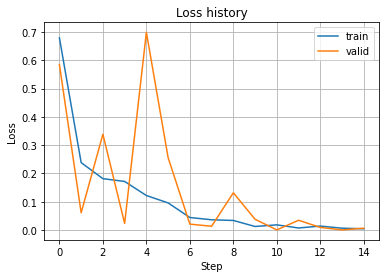

In [28]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

Влияет на метрику  - скорость обучения (снижение до определенного уровня помогает), количество эпох (тут надо смотреть - на графике видно, что 4 эпоха очень сильную ошибку дает, а 12-14 эпохи почти все к минимуму свела) и разбиение на валидационную метрику